# PPR Optimization

In [1]:
import sys

sys.path.append("..")
from src.evaluator import Evaluator
from src.optimizer import OptimizationConfig, BayesianOptimizer
from src.models.ppr import PPR, MultiAlphaPPR, TwoPhasePPR

In [2]:
evaluator = Evaluator("../data/raw/train_interactions.csv", "../data/raw/test_interactions_in.csv")

In [ ]:
configuration = OptimizationConfig(
    n_trials=100,
    n_random_starts=10,
    sample_size=10000,
    n_cv_folds=3,
    val_size=0.2,
    base_seed=42,
    metric_weights={"ndcg": 0.85, "recall": 0.15},
)

## Bayesian Optimization Setup

The optimization process was configured with the following parameters:
- Number of trials: 100
- Random start points: 10 
- Sample size: 10,000 users
- Cross-validation folds: 3
- Validation split: 20%
- Base seed: 42
- Metric weights: NDCG@20 (85%) and Recall@20 (15%)

In [ ]:
param_space = {
    "alpha": (0.0, 0.75),
    "popularity_weight": (0.0, 0.20),
    "num_iterations": (75, 600),
    "interaction_weight_processing": ["log"],
}

optimizer = BayesianOptimizer(
    recommender=PPR,
    evaluator=evaluator,
    param_space=param_space,
    config=configuration,
)
optimizer.optimize()

## Personalized PageRank (PPR) Results

### Optimized Parameters
- Alpha: 0.023
- Popularity Weight: 0.033
- Number of iterations: 93
- Playtime processing: Log transformation

### Performance Metrics
- Offline NDCG@20: 0.3449
- Offline Recall@20: 0.4172
- Execution Time: 280s (CPU), 30-45s (GPU)

### Parameter Analysis
The optimization revealed several key insights about PPR:

1. Low Alpha Value (0.023):
   - Indicates minimal reliance on random walk component
   - Places greater emphasis on the personalization vector
   - Suggests graph structure has limited influence on final recommendations

2. Near-Zero Popularity Weight (0.033):
   - Shows strong preference for personalized scores
   - Reduces influence of global popularity metrics
   - Indicates personalization alone captures relevant signals

3. Moderate Iteration Count (93):
   - Suggests relatively quick convergence
   - Balances computational cost with performance
   - Further iterations show diminishing returns

In [ ]:
param_space = {
    "alpha1": (0.0, 0.75),
    "alpha2": (0.0, 0.75),
    "stage1_k": (50, 250),
    "popularity_weight": (0.0, 0.20),
    "num_iterations": (75, 600),
    "interaction_weight_processing": ["log"],
}

optimizer = BayesianOptimizer(
    recommender=TwoPhasePPR,
    evaluator=evaluator,
    param_space=param_space,
    config=configuration,
)
optimizer.optimize()

## Two-Phase PPR Results

### Optimized Parameters
- Alpha1: 0.041
- Alpha2: 0.0
- Stage1_K: 148
- Popularity Weight: 0.0
- Number of iterations: 271

### Performance Metrics
- Offline NDCG@20: 0.3453
- Offline Recall@20: 0.4175
- Execution Time: 350s (CPU), 40-55s (GPU)

### Parameter Analysis

1. First Phase (Alpha1 = 0.041):
   - Similar to single-phase PPR
   - Slightly higher alpha for broader exploration
   - Controls initial recommendation pool

2. Second Phase (Alpha2 = 0.0):
   - Zero value makes second phase redundant
   - Effectively reduces to single-phase approach
   - Questions value of two-phase architecture

3. Stage1_K (148):
   - Moderate filtering of first-stage results
   - Shows some value in preliminary filtering
   - Limited impact on final recommendations

4. Zero Popularity Weight:
   - Confirms preference for pure personalization
   - Consistent with single-phase findings
   - Suggests popularity signals add noise

In [ ]:
param_space = {
    "alphas": [(0.0, 0.75), (0.0, 0.75), (0.0, 0.75)],
    "alpha_weights": [(0.0, 1.0), (0.0, 1.0), (0.0, 1.0)],
    "popularity_weight": (0.0, 0.20),
    "num_iterations": (75, 600),
    "interaction_weight_processing": ["log"],
}

optimizer = BayesianOptimizer(
    recommender=MultiAlphaPPR,
    evaluator=evaluator,
    param_space=param_space,
    config=OptimizationConfig(
        n_trials=100,
        n_random_starts=10,
        sample_size=10000,
        n_cv_folds=3,
        val_size=0.2,
        base_seed=42,
        metric_weights={"ndcg": 0.85, "recall": 0.15},
    ),
)
optimizer.optimize()

## Multi-Alpha PPR Results

### Optimized Parameters
- Alphas: [0.023, 0.302, 0.0]
- Alpha Weights: [1.0, 0.0, 0.0]
- Popularity Weight: 0.0
- Number of iterations: 106

### Key Findings

1. Alpha Distribution:
   - First alpha dominates (weight 1.0)
   - Higher alphas receive zero weight
   - Effectively reduces to single-alpha PPR

2. Parameter Convergence:
   - Optimal first alpha matches basic PPR
   - Additional alphas provide no benefit
   - Questions value of multiple random walks

3. Performance Impact:
   - Similar metrics to simpler variants
   - Increased computational overhead
   - No justification for added complexity

## Testing PPR with alpha=0.0

In [3]:
# PPR with alpha = 0.0
ppr = PPR(alpha=0.0, popularity_weight=0.0, num_iterations=93, interaction_weight_processing="log")
ppr_average, ppr_std = evaluator.runEvaluation(ppr, sample_size=10000, n_trials=3)

2025-05-25 13:52:00,351 - INFO - Evaluator - runEvaluation:253 - Starting evaluation with 3 trials
2025-05-25 13:52:00,352 - INFO - Evaluator - runEvaluation:255 - Using sampled dataset with 10000 users


Evaluation trials:   0%|          | 0/3 [00:00<?, ?it/s]

2025-05-25 13:52:11,038 - INFO - PPR - fit:460 - Creating user-item interaction matrix
2025-05-25 13:52:11,163 - INFO - PPR - fit:476 - Creating item-user interaction matrix


Generating recommendations:   0%|          | 0/1 [00:00<?, ?it/s]

2025-05-25 13:52:11,750 - INFO - PPR - _calculatePPR:278 - PPR converged after 1 iterations.
2025-05-25 13:52:25,463 - INFO - PPR - fit:460 - Creating user-item interaction matrix
2025-05-25 13:52:25,725 - INFO - PPR - fit:476 - Creating item-user interaction matrix


Generating recommendations:   0%|          | 0/1 [00:00<?, ?it/s]

2025-05-25 13:52:27,089 - INFO - PPR - _calculatePPR:278 - PPR converged after 1 iterations.
2025-05-25 13:52:39,169 - INFO - PPR - fit:460 - Creating user-item interaction matrix
2025-05-25 13:52:39,294 - INFO - PPR - fit:476 - Creating item-user interaction matrix


Generating recommendations:   0%|          | 0/1 [00:00<?, ?it/s]

2025-05-25 13:52:39,935 - INFO - PPR - _calculatePPR:278 - PPR converged after 1 iterations.


In [4]:
from models import Popularity

pop = Popularity()
pop_average, pop_std = evaluator.runEvaluation(pop, sample_size=10000, n_trials=3)

2025-05-25 13:52:40,103 - INFO - Evaluator - runEvaluation:253 - Starting evaluation with 3 trials
2025-05-25 13:52:40,103 - INFO - Evaluator - runEvaluation:255 - Using sampled dataset with 10000 users


Evaluation trials:   0%|          | 0/3 [00:00<?, ?it/s]

Generating recommendations:   0%|          | 0/955 [00:00<?, ?it/s]

Generating recommendations:   0%|          | 0/958 [00:00<?, ?it/s]

Generating recommendations:   0%|          | 0/969 [00:00<?, ?it/s]

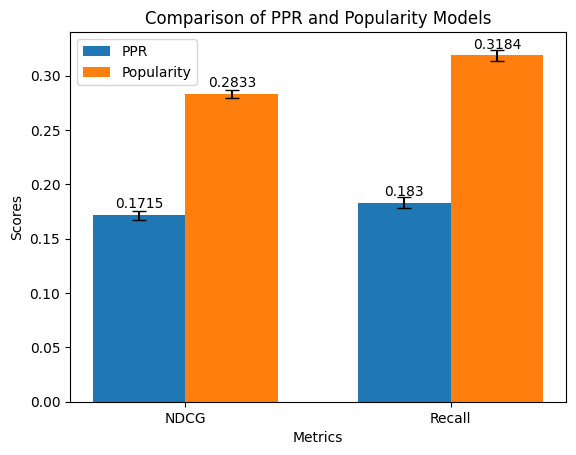

In [5]:
import matplotlib.pyplot as plt

# Data to plot
labels = ["NDCG", "Recall"]
ppr_means = [ppr_average["ndcg"], ppr_average["recall"]]
pop_means = [pop_average["ndcg"], pop_average["recall"]]
ppr_std_devs = [ppr_std["ndcg"], ppr_std["recall"]]
pop_std_devs = [pop_std["ndcg"], pop_std["recall"]]

x = range(len(labels))  # the label locations

# Plotting
fig, ax = plt.subplots()
bar_width = 0.35  # the width of the bars

# PPR bars
rects1 = ax.bar(x, ppr_means, bar_width, yerr=ppr_std_devs, label="PPR", capsize=5)

# Popularity bars
rects2 = ax.bar(
    [i + bar_width for i in x],
    pop_means,
    bar_width,
    yerr=pop_std_devs,
    label="Popularity",
    capsize=5,
)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel("Metrics")
ax.set_ylabel("Scores")
ax.set_title("Comparison of PPR and Popularity Models")
ax.set_xticks([i + bar_width / 2 for i in x])
ax.set_xticklabels(labels)
ax.legend()


# Function to add labels on bars
def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(
            f"{round(height, 4)}",
            xy=(rect.get_x() + rect.get_width() / 2, height),
            xytext=(0, 3),  # 3 points vertical offset
            textcoords="offset points",
            ha="center",
            va="bottom",
        )


add_labels(rects1)
add_labels(rects2)

plt.show()

## Alpha Insights

### Effect of Low Alpha Values
1. Personalization Vector Dominance:
   - Strong influence of user history
   - Limited graph exploration
   - Focused recommendations

2. Graph Structure Impact:
   - Minimal influence on final scores
   - Questions value of complex graph modeling
   - Suggests simpler approaches might suffice

### Alpha = 0 Case
1. Baseline Behavior:
   - Reduces to popularity-based recommendations
   - No graph structure utilization
   - Serves as effective lower bound

### Small vs Zero Alpha
1. Performance Difference:
   - Slight advantage with small non-zero alpha
   - Minimal graph structure information helps
   - Optimal balance found at very low values

### MultiAlpha Implications
1. Complexity vs Benefit:
   - Low alphas dominate optimization
   - Multiple alphas provide no advantage
   - Additional computation without gain

## Creating submissions

In [6]:
params_ppr = {
    "alpha": 0.023158004249229626,
    "popularity_weight": 0.033105547887524185,
    "num_iterations": 93,
    "interaction_weight_processing": "log",
}
evaluator.createSubmission(PPR(**params_ppr), "../output/submissions")
params_mappr = {
    "alphas": [0.022625538386329365, 0.3015889812327148, 0.0],
    "alpha_weights": [1.0, 0.0, 0.0],
    "popularity_weight": 0.0,
    "num_iterations": 106,
    "interaction_weight_processing": "log",
}
evaluator.createSubmission(MultiAlphaPPR(**params_mappr), "../output/submissions")
params_tppr = {
    "alpha1": 0.04052983557401711,
    "alpha2": 0.0,
    "stage1_k": 148,
    "popularity_weight": 0.0,
    "num_iterations": 271,
    "interaction_weight_processing": "log",
}
evaluator.createSubmission(TwoPhasePPR(**params_tppr), "../output/submissions")

2025-05-25 13:53:14,225 - INFO - Evaluator - createSubmission:307 - Starting submission creation
2025-05-25 13:53:14,231 - INFO - Evaluator - createSubmission:308 - Using recommender: PPR
2025-05-25 13:53:14,295 - INFO - PPR - fit:460 - Creating user-item interaction matrix
2025-05-25 13:53:15,080 - INFO - PPR - fit:476 - Creating item-user interaction matrix


Generating recommendations:   0%|          | 0/14 [00:00<?, ?it/s]

2025-05-25 13:53:29,427 - INFO - PPR - _calculatePPR:278 - PPR converged after 4 iterations.
2025-05-25 13:53:42,046 - INFO - PPR - _calculatePPR:278 - PPR converged after 4 iterations.
2025-05-25 13:53:55,115 - INFO - PPR - _calculatePPR:278 - PPR converged after 4 iterations.
2025-05-25 13:54:07,805 - INFO - PPR - _calculatePPR:278 - PPR converged after 4 iterations.
2025-05-25 13:54:20,597 - INFO - PPR - _calculatePPR:278 - PPR converged after 4 iterations.
2025-05-25 13:54:33,577 - INFO - PPR - _calculatePPR:278 - PPR converged after 4 iterations.
2025-05-25 13:54:46,348 - INFO - PPR - _calculatePPR:278 - PPR converged after 4 iterations.
2025-05-25 13:54:59,344 - INFO - PPR - _calculatePPR:278 - PPR converged after 4 iterations.
2025-05-25 13:55:11,848 - INFO - PPR - _calculatePPR:278 - PPR converged after 4 iterations.
2025-05-25 13:55:24,751 - INFO - PPR - _calculatePPR:278 - PPR converged after 4 iterations.
2025-05-25 13:55:37,471 - INFO - PPR - _calculatePPR:278 - PPR converg

Generating recommendations:   0%|          | 0/14 [00:00<?, ?it/s]

2025-05-25 13:56:20,265 - INFO - MultiAlphaPPR - _calculatePPR:87 - Converged after 4 iterations for alpha 0.022625538386329365
2025-05-25 13:56:45,437 - INFO - MultiAlphaPPR - _calculatePPR:87 - Converged after 8 iterations for alpha 0.3015889812327148
2025-05-25 13:56:48,634 - INFO - MultiAlphaPPR - _calculatePPR:87 - Converged after 1 iterations for alpha 0.0
2025-05-25 13:57:01,961 - INFO - MultiAlphaPPR - _calculatePPR:87 - Converged after 4 iterations for alpha 0.022625538386329365
2025-05-25 13:57:26,983 - INFO - MultiAlphaPPR - _calculatePPR:87 - Converged after 8 iterations for alpha 0.3015889812327148
2025-05-25 13:57:30,288 - INFO - MultiAlphaPPR - _calculatePPR:87 - Converged after 1 iterations for alpha 0.0
2025-05-25 13:57:44,408 - INFO - MultiAlphaPPR - _calculatePPR:87 - Converged after 4 iterations for alpha 0.022625538386329365
2025-05-25 13:58:10,597 - INFO - MultiAlphaPPR - _calculatePPR:87 - Converged after 8 iterations for alpha 0.3015889812327148
2025-05-25 13:58

Generating recommendations:   0%|          | 0/14 [00:00<?, ?it/s]

2025-05-25 14:07:01,028 - INFO - TwoPhasePPR - _calculatePPR:75 - Converged after 4 iterations
2025-05-25 14:07:08,775 - INFO - TwoPhasePPR - _calculatePPR:94 - Converged after 1 iterations
2025-05-25 14:07:28,139 - INFO - TwoPhasePPR - _calculatePPR:75 - Converged after 4 iterations
2025-05-25 14:07:35,180 - INFO - TwoPhasePPR - _calculatePPR:94 - Converged after 1 iterations
2025-05-25 14:07:54,091 - INFO - TwoPhasePPR - _calculatePPR:75 - Converged after 4 iterations
2025-05-25 14:08:01,257 - INFO - TwoPhasePPR - _calculatePPR:94 - Converged after 1 iterations
2025-05-25 14:08:28,417 - INFO - TwoPhasePPR - _calculatePPR:75 - Converged after 4 iterations
2025-05-25 14:08:32,555 - INFO - TwoPhasePPR - _calculatePPR:94 - Converged after 1 iterations
2025-05-25 14:08:48,001 - INFO - TwoPhasePPR - _calculatePPR:75 - Converged after 4 iterations
2025-05-25 14:08:52,012 - INFO - TwoPhasePPR - _calculatePPR:94 - Converged after 1 iterations
2025-05-25 14:09:08,264 - INFO - TwoPhasePPR - _ca

('../output/submissions/submission_TwoPhasePPR_20250525_141056.csv',
 '../output/submissions/submission_TwoPhasePPR_20250525_141056.zip')